In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pdb
import imutils

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Helper function

def threshold(img, thresh):
  # Convert image to a binary image using a threshold
  _, thresh_output = cv2.threshold(img, thresh, 255.0, cv2.THRESH_BINARY)
  return thresh_output

def resize(img):
  # Resize image to be 1/10 of original
  rows = img.shape[0]
  cols = img.shape[1]
  img_resized = cv2.resize(img, (cols//5, rows//5))
  return img_resized

def erode(img, kernel_size=4):
  # Erode image (pixels in original images are kept only
  # if all pixels in kernel are also 1)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
  img_eroded = cv2.erode(img, kernel)
  return img_eroded

def dilate(img, kernel_size=4):
  # Dilate image (pixels are kept if at least one pixel in
  # the kernel is also 1)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
  img_dilated = cv2.dilate(img, kernel)
  return img_dilated

def skin_detect(img):
  """
  Determines whether a pixel represents skin based on RGB value
  Based on "A Survey on Pixel-Based Skin Color Detection Techniques" (Vezhnevets et al)
  """
  dst = np.zeros(np.shape(img)[:-1], dtype=np.uint8)

  # (R, G, B) classified as skin if
  # 1) R>95, G>40, B>20,
  # 2) max{R,G,B} - min{R,G,B} > 15
  # 3) |R-G| > 15 and R > G and R > B
  mask = np.logical_and.reduce((img[:,:,0] > 20, img[:,:,1]>40, img[:,:,2]>95,
                                img.max(axis=-1) - img.min(axis=-1) > 15,
                                abs(img[:,:,2] - img[:,:,1]) > 15,
                                img[:,:,2] > img[:,:,1], img[:,:,2] > img[:,:,0]))

  dst[mask] = 255
  return dst

def compute_area(binary):
  # Compute area (0th moment) of binary image
  area = np.sum(np.sum(binary==255))
  return area

def init_canvas(size):
  # Create a blank binary canvas
  cols, rows = size
  canvas = np.zeros((rows, cols)).astype(np.uint8)
  return canvas

def compute_centroid(binary):

  # if(np.max(binary)>2):
  #   neg_binary = binary//255
  # else:
  #   neg_binary = binary

  area = compute_area(binary)
  testrow_x = np.sum(np.where(binary.T == 255)[0])
  x_c = int(testrow_x//area)

  testcol_y = np.sum(np.where(binary == 255)[0])
  y_c = int(testcol_y//area)

  return x_c, y_c

def compute_alpha(binary):
  # Compute the angle of the principle axis of a binary image
  # 0th moment
  area = compute_area(binary)
  # 1st moments
  x_centroid, y_centroid = compute_centroid(binary)

  #vectorized
  a_test = 0
  b_test = 0
  c_test = 0
  #gives indexes of rows - centroid
  binary_ydir = np.arange(np.size(binary)).reshape(binary.shape)
  binary_xdir = np.arange(np.size(binary)).reshape((binary.shape[1],binary.shape[0])).T

  # subtracting row width from column to get correct division
  binary_ydir_rounddown = binary_ydir//binary.shape[1]
  binary_ydir_norm = binary_ydir_rounddown-y_centroid

  binary_xdir_rounddown = binary_xdir//binary.shape[0]
  binary_xdir_norm = binary_xdir_rounddown-x_centroid

  #multiply row number by column number
  binary_index_product = (binary_xdir_norm) * (binary_ydir_norm)

  #gives indexes of col - centroid x (root(a))
  testcol_x = np.where(binary.T == 255)[0] - x_centroid

  #gives indexes of row - centroid y (root(c))
  testrow_y = np.where(binary == 255)[0] - y_centroid

  test_row_col = np.where(binary == 255,binary_index_product,0)

  a_test = np.sum(np.square(testcol_x))
  b_test = np.sum(test_row_col)
  c_test = np.sum(np.square(testrow_y))

  if a_test == c_test:
    alpha_test = np.pi/2
  else:
    alpha_test = 0.5*np.arctan(b_test/(a_test-c_test))
  return alpha_test


### The functions below were not used in the final version ###

# def compute_first_moments(binary):
#   # Compute x and y centroids (1st moments) of binary image
#   area = compute_area(binary)
#   x_sum = 0
#   y_sum = 0
#   for i in range(binary.shape[0]):
#     for j in range(binary.shape[1]):
#       if binary[i, j] == 0:
#         x_sum +=j
#         y_sum +=i
#   x_c = int(x_sum//area)
#   y_c = binary.shape[0] - int(y_sum//area) # y goes from bottom down

#   return x_c, y_c


# def compute_alpha_old(binary):
#   # Compute the angle of the principle axis of a binary image
#   # 0th moment
#   area = compute_area(binary)
#   # 1st moments
#   x_centroid, y_centroid = compute_centroid(binary)

#   a = 0
#   b = 0
#   c = 0
#   # 2nd moments
#   for i in range(binary.shape[0]):  # rows
#     for j in range(binary.shape[1]):  # cols
#       if binary[i,j] == 255:
#         a += (j - x_centroid)**2
#         b += (j - x_centroid)*(i - y_centroid)
#         c += (i - y_centroid)**2
#   # Compute angle of principal axis
#   if a == c:
#     alpha = np.pi/2
#   else:
#     alpha = 0.5*np.arctan(b/(a-c))
#   return alpha

# def rotate_object(frame_thresh, alpha, canvas):
#   rot_angle = -2*alpha
#   # Rotates an object in a binary image
#   for i in range(frame_thresh.shape[0]):
#     for j in range(frame_thresh.shape[1]):
#       if frame_thresh[i,j] > 0:
#         x_rot = int(np.cos(rot_angle)*i - np.sin(rot_angle)*j)
#         y_rot = int(np.cos(rot_angle)*j + np.sin(rot_angle)*i)
#         if x_rot >= frame_thresh.shape[0]-1:
#           x_rot = frame_thresh.shape[0]-1
#         if y_rot >= frame_thresh.shape[1]-1:
#             y_rot = frame_thresh.shape[1]-1
#         canvas[x_rot, y_rot] = 255
#   return canvas

# def count_peaks(freq, thresh):
#   # Count the number of peaks (defined by threshold value)
#   # in a pixel histogram
#   count = 0
#   for idx in range(len(freq) - 1):
#     if freq[idx+1] > thresh and freq[idx] < thresh:
#       count += 1
#   return count

In [ ]:
def finger_detection(img, show_result=False):
  # Count the number of fingers held up in the image
  img = resize(img)

  # Threshold image for skin pixels
  img_thresh = skin_detect(img)

  # Compute alpha of thresholded image
  alpha = compute_alpha(img_thresh)

  # Initialize blank canvas
  canvas = init_canvas((img_thresh.shape[1], img_thresh.shape[0]))

  # Rotate object to be aligned vertically
  # img_thresh_rot = rotate_object(img_thresh, alpha, canvas)
  rot_ang = alpha * (180/np.pi)
  img_thresh_rot = imutils.rotate(img_thresh, rot_ang)
  # cv2_imshow(img_thresh_rot)

  # Compute centroid of rotated image
  x_c_rot, y_c_rot = compute_centroid(img_thresh_rot)

  ### hyperparameter (0.6) for cutoff height
  img_thresh_rot_crop = img_thresh_rot[:int(0.6*y_c_rot), :]

  # Erode and dilate
  # img_thresh_rot_crop = erode(img_thresh_rot_crop, kernel_size=6)
  # img_thresh_rot_crop = dilate(img_thresh_rot_crop, kernel_size=4)

  # # Get countours
  contours, _ = cv2.findContours(img_thresh_rot_crop, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  num_fingers = 0
  for contour in contours:
    if cv2.contourArea(contour) > 50:
      num_fingers += 1

  text = f"Fingers: {num_fingers} "
  img_copy = img.copy()
  img_text = cv2.putText(img=img_copy, text=text, org=(10,20), fontFace=2,
                         fontScale=0.5, color=(0,0,255), thickness=1, lineType=cv2.LINE_AA)
  cv2.imwrite('labeled_finger.png', img_text)
  if show_result:
    cv2_imshow(img_text)

  return num_fingers, img_text


In [ ]:
# Middle finger censoring

def censor(img, show_result=False, show_hist=False):
  num_fingers, _ = finger_detection(img, show_result=False)
  # Count the number of fingers held up in the image
  img = resize(img)

  # Threshold image for skin pixels
  img_thresh = skin_detect(img)

  # Compute alpha of thresholded image
  alpha = compute_alpha(img_thresh)
  rot_ang = alpha * (180/np.pi)

  # Rotate object to be aligned vertically (rotate functions needs degrees)
  img_thresh_rot = imutils.rotate(img_thresh, rot_ang)

  # Compute centroid of rotated image
  x_c_rot, y_c_rot = compute_centroid(img_thresh_rot)

  # Crop
  img_thresh_rot_crop = img_thresh_rot[:y_c_rot, :]
  # Compute new centroid of cropped image
  x_c, y_c = compute_centroid(img_thresh_rot_crop)

  freq = np.sum(img_thresh_rot_crop > 0, axis=0)
  mode = np.where(freq == np.max(freq))[0][0]

  # If desired, create a histogram of pixel x-coordinates
  if show_hist:
    x_vals = range(img_thresh_rot_crop.shape[1])
    y_vals = range(img_thresh_rot_crop.shape[0])
    plt.plot(x_vals, freq)
    plt.plot(x_c*np.ones(len(y_vals)), y_vals, 'r')
    plt.plot(int(mode)*np.ones(len(y_vals)), y_vals, 'g')
    plt.xlabel('x-coordinate')
    plt.ylabel('frequency')
    plt.show()

  # Check that there is only one finger
  flag1 = (num_fingers == 1)

  # Chech that the finger is in the middle of the hand
  threshold = 18
  flag2 = mode - x_c < 28 and mode - x_c >-5


  # Get countours
  if img_thresh_rot_crop.size != 0:
    img_dilate = dilate(img_thresh_rot_crop, kernel_size=8)
    contours, _ = cv2.findContours(img_dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  img_out = img.copy()
  if flag1 and flag2: # middle finger detected
    text = "Censored!"

    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect)
    top_left = (int(box[0][0]), int(box[0][1]))
    bottom_right = (int(box[2][0]), int(box[2][1]))
    color = (0,0,255)
    thickness = -1
    img_out = cv2.rectangle(img_out, top_left, bottom_right, color, thickness)

  else: # normal finger detection
    text = f"Fingers: {num_fingers} "

  img_out = cv2.putText(img_out, text=text, org=(20,30), fontFace=2,
                      fontScale=1.5, color=(0,255,0), thickness=1, lineType=cv2.LINE_AA)

  if show_result:
    cv2_imshow(img_out)

  return img_out

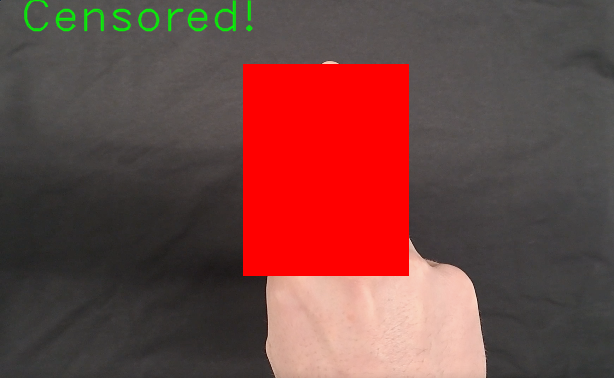

True

In [ ]:
# Testing functions on video
# vidcap = cv2.VideoCapture('drive/MyDrive/CS585/Hand gesture detection/New videos/finger counting roger reupload.mp4')
vidcap = cv2.VideoCapture('test_video.mp4')
vidwrite = cv2.VideoWriter('finger_detected.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 30, (349,216))
ret, img = vidcap.read()

while (ret):
  img_detect = censor(img)
  vidwrite.write(cv2.resize(img_detect, (349,216)))
  ret, img = vidcap.read()
vidwrite.release()
print("Success")